## **Interactive Ocean Data Analysis with NSDF Services - NSDF-OpenVisus**

This notebook provides a step-by-step guide for accessing, visualizing, and analyzing cloud-hosted oceanographic data using the **OpenVisus** framework.  
The data comes from the **LLC2160 ocean simulation**, part of the [DYAMOND Visualization Dataset](https://data.nas.nasa.gov/viz/vizdata/DYAMOND_c1440_llc2160/GEOS/index.html), and includes multi-terabyte fields such as salinity, sea-surface temperature, and 3D ocean velocities.

### 🔍 What You Can Do with This Notebook:
- Interactively load and inspect ocean simulation data at various **resolutions**, **timesteps**, and **depths**
- Select and analyze **regions of interest (ROIs)** for targeted exploration
- Visualize large-scale salinity fields and **extract subsets** based on physical thresholds
- Perform **quantitative analysis** using binary masks and voxel statistics
- Compare how **resolution impacts accuracy and performance**

The notebook is structured into clear workflow steps (see figure below), enabling progressive exploration from global patterns to local features.


## **Step 1: Import Required Libraries**

In this step, we import the Python libraries needed for data access, analysis, and visualization.

- `numpy`: for numerical operations on arrays  
- `matplotlib.pyplot`: for generating visualizations  
- `os`: for setting environment variables  
- `time`: for measuring execution duration  
- `OpenVisus`: to load and read the cloud-hosted IDX datasets

These libraries provide the core functionality used throughout this notebook to work with large-scale oceanographic data.


In [1]:
# Step 1a: Import Required Libraries and Set Up Environment

# Import standard libraries
import numpy as np                 # For numerical operations
import os                         # For environment variable configuration
import time                       # For tracking execution time
import matplotlib.pyplot as plt   # For plotting and visualization

# Set the cache directory for OpenVisus
os.environ["VISUS_CACHE"] = "./visus_cache_can_be_erased"

# Import OpenVisus library for reading IDX datasets from the cloud
from OpenVisus import *

# Start the execution timer
start_time = time.time()

print('Step 1a) Imported libraries and initialized environment.')


Step 1a) Imported libraries and initialized environment.


### Available LLC2160 Datasets in the Cloud

The datasets listed below represent different physical fields from the LLC2160 global ocean simulation.  
Each dataset is over **200 TB** in size and is hosted on the cloud via **OSDF** for scalable, on-demand access.

You can select any of these fields for analysis by referencing their corresponding URLs defined in the next cell.

In [2]:
# Set your variable of interest

variable='salt' # options are: u,v,w,salt,theta

In [3]:
# Step 1b: Define Cloud-Based LLC2160 Dataset URLs

# These variables point to IDX-formatted datasets hosted on  OSDF
# Each URL provides access to a different physical variable from the LLC2160 ocean simulation

base_url= "https://nsdf-climate3-origin.nationalresearchplatform.org:50098/nasa/nsdf/climate3/dyamond/"
if variable=="theta" or variable=="w":
    base_dir=f"mit_output/llc2160_{variable}/llc2160_{variable}.idx"
elif variable=="u":
    base_dir= "mit_output/llc2160_arco/visus.idx"
else:
    base_dir=f"mit_output/llc2160_{variable}/{variable}_llc2160_x_y_depth.idx"
    
field= base_url+base_dir

print("Step 1b done: Defined dataset URLs for u, v, w velocity components, temperature, and salinity.")


Step 1b done: Defined dataset URLs for u, v, w velocity components, temperature, and salinity.


In [4]:
#Check python verions (make sure you don't have an error here), it should just print out Python and the version numbers
!python --version

Python 3.11.11


## **Step 2: Read Metadata from the Cloud**

In this step, we read the metadata associated with a dataset hosted on the cloud.

The function `LoadDataset()` loads only the metadata—such as dimensions, number of timesteps, available fields, and data types—without downloading the full dataset. This allows you to inspect the structure and properties of the dataset before selecting a specific time or region in later steps.

 

In [5]:
# Step 2: Load dataset metadata for salinity and print key attributes

# Load metadata for the salinity dataset
db = LoadDataset(field)

# Retrieve dimensions from the dataset's logic box: (depth, longitude, latitude)
depth_levels     = db.getLogicBox()[1][0]
longitude_levels = db.getLogicBox()[1][1]
latitude_levels  = db.getLogicBox()[1][2]

# Print dimension information
print(f"Dimensions (depth × lon × lat): {depth_levels} × {longitude_levels} × {latitude_levels}")
print("Note: These dimensions will be used to interpret axes in the salinity plots.\n")

# Print number of available timesteps
print(f"Total Timesteps: {len(db.getTimesteps())}")

# Print field name and data type
print(f"Field: {db.getField().name}")
print("Data Type: float32")

print("Step 2 done.")

Dimensions (depth × lon × lat): 8640 × 6480 × 90
Note: These dimensions will be used to interpret axes in the salinity plots.

Total Timesteps: 10366
Field: salt
Data Type: float32
Step 2 done.


## **Step 3: Data Selection**

In this step, we demonstrate how to load a subset of the salinity dataset into a NumPy array for analysis. You can customize the selection based on:

- **Timestep**: Choose any available time index; if none is specified, the first timestep is used by default.
- **Spatial Region (x, y, z)**: Select a specific portion of the 3D volume (longitude, latitude, depth).
- **Data Quality (Resolution)**: Set the `quality` parameter to control resolution. Lower values (e.g., -15) give coarser data for faster loading; `0` represents full resolution but may result in slower performance due to the large file size.

This flexibility allows you to focus on particular time slices or spatial subregions relevant to your analysis while balancing performance with data granularity.


In [6]:
# here you can select the resoution at which you query the data: -15 is very coarse, 0 is full resoltuon (dangerous since you may fetch a lot of data and wait a long time).
data_resolution = -9 # try values among -15, -12, -9, -6, -3, 0
data3D=db.read(time=0,quality=data_resolution)
print(data3D.shape)
print(np.min(data3D),np.max(data3D))
print('Step 3 done.')

(12, 810, 1080)
0.0 50.94112
Step 3 done.


## **Step 4: Visualize the Data**

In this step, we move from raw numerical data to visual interpretation by generating 2D salinity maps using `matplotlib`. Since our dataset is already in NumPy array format, it can be visualized using any Python-compatible visualization library (e.g., `matplotlib`, `plotly`, or `holoviews`).

We begin by plotting the full 2D salinity field at a selected depth and resolution. This allows us to visually identify large-scale oceanographic features such as gyres, fronts, and outflows. To emphasize relevant salinity patterns, we apply a colormap and set the salinity value range using `vmin` and `vmax`. You can adjust these values depending on the salinity range you're targeting for analysis.

Next, we filter the salinity values to isolate a specific range of interest—typically one associated with water mass boundaries or climate-sensitive zones (e.g., 34.0–35.9 PSU). This range is used to build:
- A **masked salinity map** showing only values within that range (Step 4c),
- And a **binary map** highlighting the spatial distribution of those regions (Step 4d).

These visualizations are critical to understanding how ocean regions are organized in terms of salinity and help guide further quantitative analysis in Step 5. They also provide a foundation for tracking changes over time, which is essential for climate studies.

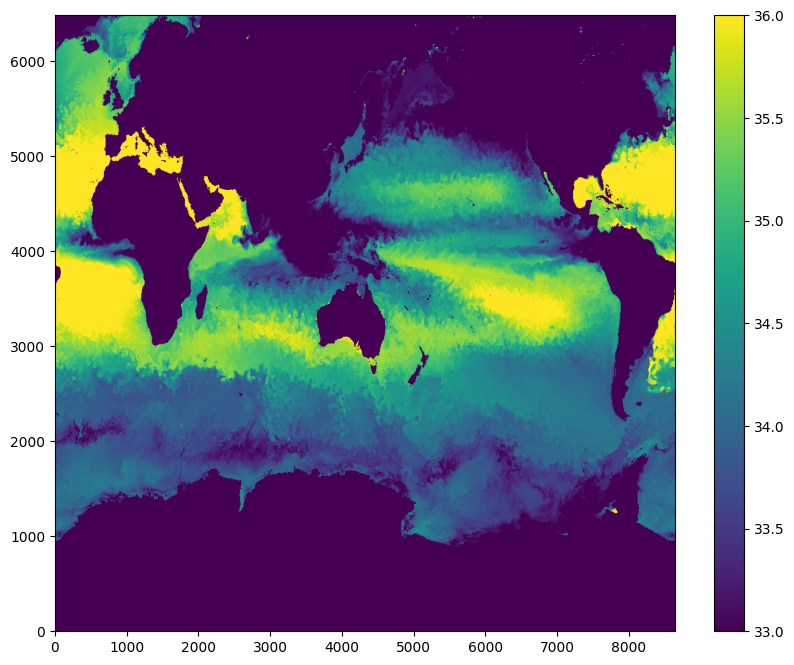

Step 4a done.


In [7]:
# Step 4a) Plot all the data for the field set in Step 2
depth = 0  # between 0 and 89
depth = int(depth / db.getLogicBox()[1][2] * data3D.shape[0])
data = data3D[depth, :, :]

fig, axes = plt.subplots(1, 1, figsize=(10, 8))
axes.set_xlim(0, 8640)
axes.set_ylim(0, 6480)

# Plot the full salinity field
axp = axes.imshow(
    data,
    extent=[0, 8640, 0, 6480],
    aspect='auto',
    origin='lower',
    vmin=33,
    vmax=36,
    cmap='viridis'
)
plt.colorbar(axp, location='right')

plt.show()

print('Step 4a done.')

In [8]:
# Step 4b) Analyze salinity values within a target range

# Define salinity range of interest
min_salinity = 34.0
max_salinity = 35.9

# Create a binary mask for land:
# Set to 1 where salinity is 0 (land), 0 elsewhere
data_land = np.where(data == 0, 1, 0)

# Create a binary mask for sea:
# Set to 1 where salinity > 0 (ocean), 0 where it's land
data_sea = np.where(data == 0, 0, 1)

# Isolate only values within the defined salinity range
# Set values < min_salinity to 0
data_restricted = np.where(data > min_salinity, data, 0)

# Set values > max_salinity to 0
data_restricted = np.where(data_restricted < max_salinity, data_restricted, 0)

print('Step 4b done.')



Step 4b done.


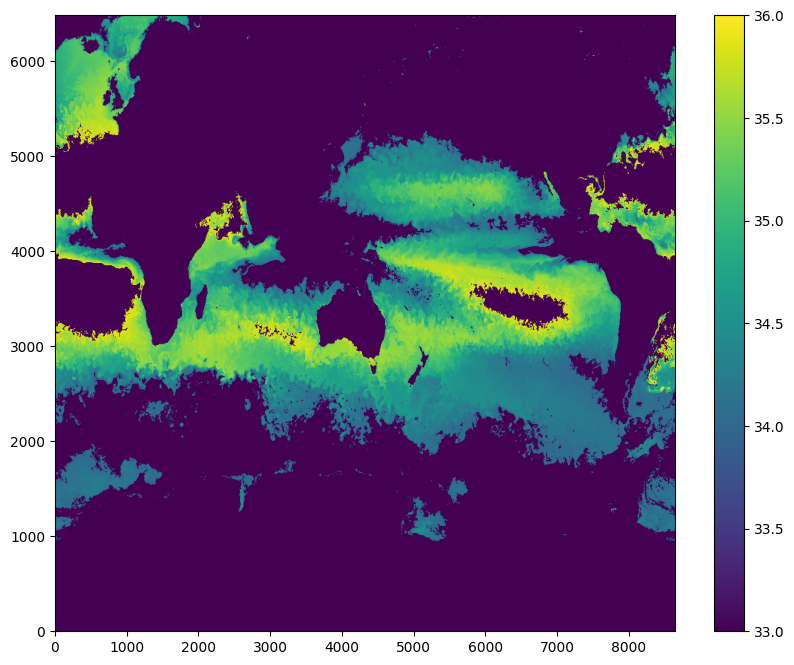

Step 4c done.


In [9]:
# Step 4c) Visualize the filtered salinity field (data_restricted)

# Create a plot to display only values within the selected salinity range
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Set full spatial extent of the LLC2160 grid
axes.set_xlim(0, 8640)
axes.set_ylim(0, 6480)

# Plot the restricted salinity data using the same color scale as original
axp = axes.imshow(
    data_restricted,
    extent=[0, 8640, 0, 6480],
    aspect='auto',
    origin='lower',
    vmin=33,
    vmax=36,
    cmap='viridis'
)

# Add a colorbar to indicate salinity scale
plt.colorbar(axp, location='right')

# Show the figure
plt.show()

print('Step 4c done.')



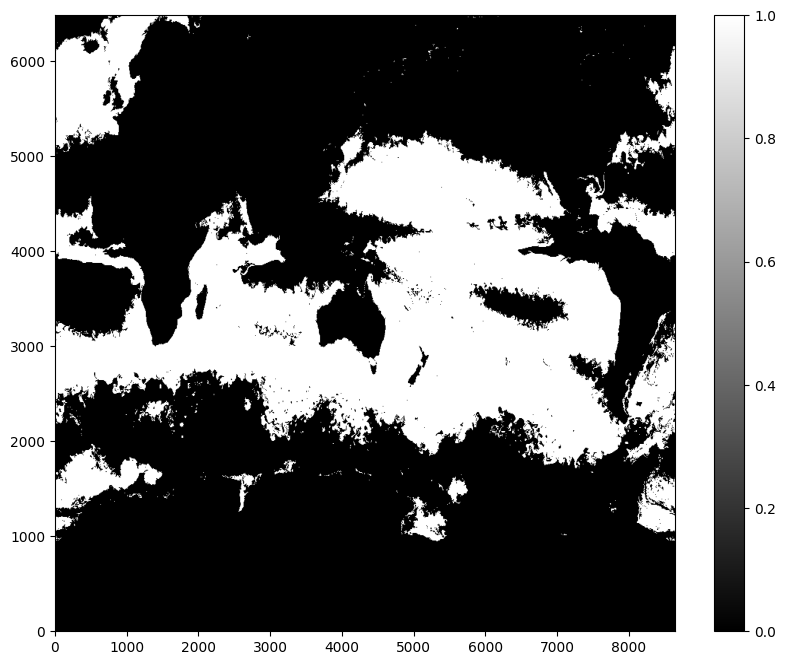

Step 4d done.


In [10]:
# Step 4d) Plot a binary map showing where salinity is within the selected range

# Convert data_restricted to a binary image:
# Set to 1 where salinity is in range, 0 elsewhere
data_binary = np.where(data_restricted > 0, 1, 0)

# Create a plot to visualize the binary salinity mask
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Set the full spatial extent of the grid
axes.set_xlim(0, 8640)
axes.set_ylim(0, 6480)

# Display binary mask using a grayscale color map
axp = axes.imshow(
    data_binary,
    extent=[0, 8640, 0, 6480],
    aspect='auto',
    origin='lower',
    vmin=0,
    vmax=1,
    cmap='gray'
)

# Add a colorbar showing 0 (outside range) and 1 (within range)
plt.colorbar(axp, location='right')

# Show the figure
plt.show()

print('Step 4d done.')

## **Step 5: Calculate the percentage of voxels within the selected salinity range**

In this step, we move from visual inspection to quantitative analysis. We calculate the fraction of grid cells (voxels) that fall within the selected salinity range (e.g., 34.0–35.9 PSU), and compare that to the total number of ocean and land voxels.

### 📊 What This Step Reveals

- **What fraction of the Earth's surface—or ocean—falls within the target salinity range?**
- **Are these regions globally distributed or concentrated in specific zones?**
- **How does the salinity-covered area compare to land and total ocean area?**

### 🌍 Why This Matters for Climate Analysis

- **Detects Climate-Driven Shifts Over Time**  
  By repeating this calculation over multiple timesteps, we can observe how the spatial extent of key salinity ranges shifts due to climate change.

- **Separates Ocean from Land Effects**  
  Land voxels are excluded to ensure ocean-only coverage is accurately measured, which is essential for physical oceanographic studies.

- **Informs Regional and Global Diagnostics**  
  The results support further analysis of dynamic features such as subtropical gyres, salinity fronts, and freshwater input zones (e.g., melting polar ice).


In [11]:
# Step 5) Quantify salinity coverage across land, ocean, and global domains

# Calculate total number of voxels in the 2D data slice
total_voxels = data.shape[0] * data.shape[1]

# Count voxels identified as land (where salinity == 0)
land_voxels = np.sum(data_land)

# Count voxels within the selected salinity range (white in binary map)
salinity_voxels = np.sum(data_binary)

# Print basic counts
print("Test at data resolution:", data_resolution)
print("Total voxels:", total_voxels)
print("Land voxels:", land_voxels)
print("Voxels within salinity range:", salinity_voxels)

# Compute and print percentages
print("Percentage of land area:", '{:.2%}'.format(land_voxels / total_voxels))
print("Percentage of global ocean within salinity range:", '{:.2%}'.format(salinity_voxels / total_voxels))
print("Percentage of water (non-land) within salinity range:", 
      '{:.2%}'.format(salinity_voxels / (total_voxels - land_voxels)))

# Track execution time
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
print("Step 5 done.")

Test at data resolution: -9
Total voxels: 874800
Land voxels: 380479
Voxels within salinity range: 261747
Percentage of land area: 43.49%
Percentage of global ocean within salinity range: 29.92%
Percentage of water (non-land) within salinity range: 52.95%
Execution time: 3.73 seconds
Step 5 done.


## **OBSERVE: Summary of Test Results at Different Resolutions (Desktop)**

This section summarizes how analysis results can change depending on the resolution of the data loaded.  
In previous steps, you may have chosen a specific data resolution using the `quality` parameter (e.g., `-15`, `-9`, `0`).

**Note:** You are encouraged to go back, adjust the resolution value, and rerun the analysis to compare results.

---

### 🧠 Why Resolution Matters

The `quality` setting controls the level of spatial detail in the dataset:
- **Higher resolution (e.g., `0`)** → more detailed data, larger file size, longer load times
- **Lower resolution (e.g., `-15`)** → faster to load, but less spatial accuracy

This can impact your results because:
- Finer features (e.g., narrow salinity fronts or coastal gradients) may be lost at lower resolutions
- Quantitative results (e.g., voxel counts in a salinity range) will differ due to coarser spatial sampling

---

## **Step 6: User Exercise**

Change the data resolution and re-run your analysis.

> **Question:** How do the results change as you decrease the resolution?  
> 
> Try comparing the number of voxels within the salinity range and note how the **accuracy degrades** at coarser levels.

Remember:  
**Lower resolution = fewer voxels = faster but less precise.**


## **Step 6: Expected Answers **

Test at data resolution  0 <br>
55987200 24342221 16750511 <br>
percentage of land voxels 43.48% <br>
percentage of world voxels within the salinity range 29.92% <br>
percentage of water voxels within the salinity range 52.93% <br>
Execution time: 1016.64 seconds <br>


Test at data resolution  -3 <br>
13996800 6086076 4187586 <br>
percentage of land voxels 43.48% <br>
percentage of world voxels within the salinity range 29.92%<br>
percentage of water voxels within the salinity range 52.94%  <br>
Execution time: 128.61 seconds (13.97 seconds with cache)<br>

Test at data resolution  -6  <br>
3499200 1521669 1046818 <br>
percentage of land voxels 43.49% <br>
percentage of world voxels within the salinity range 29.92%<br>
percentage of water voxels within the salinity range 52.94% <br>
Execution time: 16.96 seconds (3.29 seconds with cache)<br>
<br>
Test at data resolution  -15  <br>
54810 23921 16356 <br>
percentage of land voxels 43.64% <br>
percentage of world voxels within the salinity range 29.84% <br>
percentage of water voxels within the salinity range 52.95% <br>
Execution time: 1.57 seconds (1.19 seconds with cache) <br>


## **Step 7: What if you want to view the full-resolution data for a specific region and depth?**

To focus your analysis on a particular area, you can define a **bounding box** (x, y) and a specific **depth level (z)** when reading the data.

- `x` and `y`: specify the horizontal region of interest using coordinate ranges (longitude and latitude indices).
- `z`: selects the vertical layer (depth index) to extract.

This allows you to:
- Avoid loading the entire global dataset
- Zoom into a smaller region with full spatial detail
- Re-run the analysis and visualizations on just this region

This approach is useful when studying localized phenomena such as eddies, upwelling zones, or boundary currents.

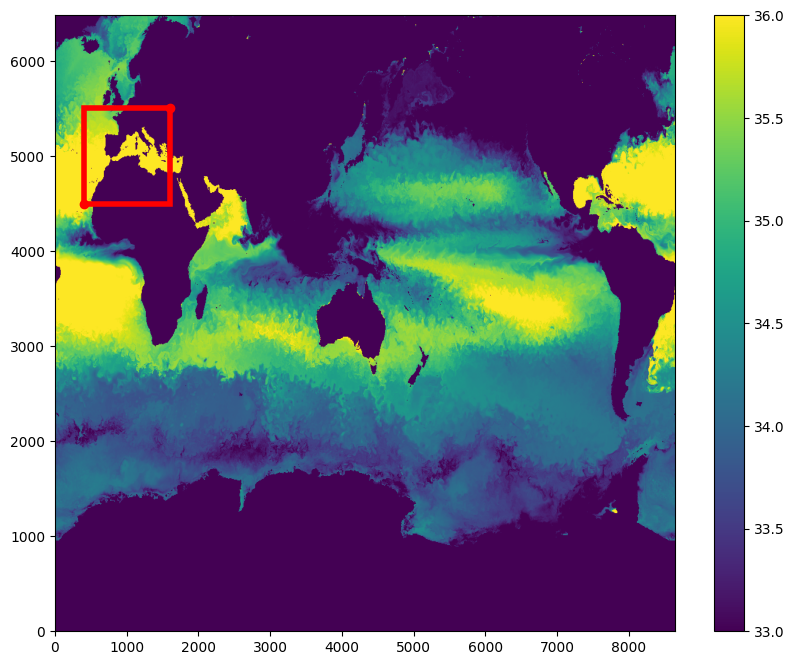

Step 8a done.


In [12]:
# Step 7a: Define and visualize a new region of interest using the full salinity field

# Create a full-extent plot of the data
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
axes.set_xlim(0, 8640)
axes.set_ylim(0, 6480)

# Plot the full 2D salinity field
axp = axes.imshow(
    data,
    extent=[0, 8640, 0, 6480],
    aspect='auto',
    origin='lower',
    vmin=33,
    vmax=36,
    cmap='viridis'
)

# Add a colorbar to the right
plt.colorbar(axp, location='right')

# Define the corners of the subregion of interest

# For Agulhas Current, we can use the following coordinates
# These coordinates are approximate and can be adjusted based on the specific area of interest
# x1, x2 are longitude coordinates (in pixels)
# y1, y2 are latitude coordinates (in pixels)
x1, x2 = 800, 2400
y1, y2 = 2500, 3500

# For Strait of Gibraltar, we can use the following coordinates:
x1, x2 = 400, 1600
y1, y2 = 4500, 5500


# Draw a red rectangle around the selected region
regionRect = plt.Rectangle(
    xy=(x1, y1),
    width=(x2 - x1),
    height=(y2 - y1),
    color='r',
    fill=False,
    linewidth=4
)
axes.add_patch(regionRect)

# Optionally mark the corners of the region
axes.plot([x1, x2], [y1, y2], 'ro')  # red circles

# Display the plot
plt.show()

print("Step 8a done.")


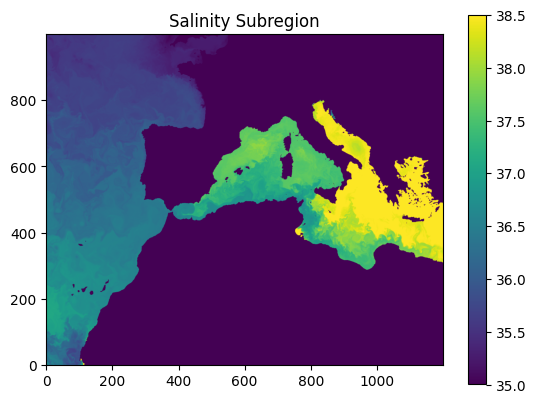

Step 7b done.


In [13]:
# Step 7b: Read and visualize a subregion of the dataset

# Use the bounding box defined in Step 7a (x1, x2, y1, y2)
# Read a single depth layer (z = 0) and the selected spatial region into 'data_sub'
data_sub = db.read(
    time=0,       # timestep index
    z=[0, 1],     # depth range (layer 0 only)
    x=[x1, x2],   # longitude pixel range
    y=[y1, y2]    # latitude pixel range
)

# Plot the extracted subregion
plt.imshow(
    data_sub[0, :, :],
    origin='lower',
    vmin=35,
    vmax=38.5,
    cmap='viridis'
)
plt.colorbar()
plt.title("Salinity Subregion")
plt.show()

print("Step 7b done.")

### 📬 Need Help?

If you have any questions, feedback, or encounter issues while using this notebook, please feel free to reach out to the team:

- **Aashish Panta** — aashishpanta0@gmail.com  
- **Valerio Pascucci** - pascucci.valerio@gmail.com